# Interaction with MSNoise and plotting dv/v

## Importing modules and libraries

In [1]:
import msnoise.api as ms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import datetime

C:\Users\julie\anaconda3\lib\site-packages\msnoise\_version.py:153: UserWarning: msnoise could not determine its version number. Make sure it is properly installed. This for example happens when installing from a zip archive of the msnoise repository which is not a supported way of installing msnoise.
  warnings.warn("msnoise could not determine its version number. Make "


## Interacting with MSNoise

In [2]:
# Connecting to the database of MSNoise

path_ini = 'D:\\MEMOIRE\\MSNoise\\master\\db.ini'
database = ms.connect(inifile=path_ini)

In [9]:
NET = ms.get_networks(database)
STA = ['BJK','DJK','HUS','VOT','JOK','KSK','URH','GRF','KVI']

In [17]:
for sta in STA :
    ms.mark_data_availability(database, 'VI', sta, 'A')
ms.is_next_job(database, flag='T', jobtype='CC')

False

In [ ]:
#ms.get_filters(database, all=True)

In [ ]:
#ms.update_filter(database,ref=2,low=1.0,high=2.0,mwcs_low=1.0,mwcs_high=2.0, mwcs_wlen=120, 
                     mwcs_step=60 , rms_threshold=0, used=True)

## dvv plotting

### Specify the root of dtt files and pair station names

In [3]:
component = 'ZZ'
mwlength = '015'
filterID = '02'

# Root of the dtt files to plot
root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
folder = os.listdir(root)
# Root of the stations pairs names
rootpair = 'D:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
pair_name = os.listdir(rootpair)

### Example of a dtt files

In [4]:
df = pd.read_csv(root+folder[0])

In [5]:
df

,Date,Pairs,M,EM,A,EA,M0,EM0
0,2018-01-01,VI_BJK_VI_DJK,0.001665,0.001753,0.025267,0.019365,0.003663,0.000911
1,2018-01-01,VI_BJK_VI_GRF,0.000067,0.001406,-0.033346,0.016035,-0.002058,0.001204
2,2018-01-01,VI_BJK_VI_URH,-0.001969,0.000967,0.007123,0.019827,-0.001975,0.000855
3,2018-01-01,VI_DJK_VI_GRF,0.002849,inf,0.008134,inf,0.002546,0.000363
4,2018-01-01,VI_DJK_VI_URH,-0.001092,0.002263,-0.034087,0.042338,0.000039,0.001666
5,2018-01-01,ALL,0.002319,0.000900,0.011211,0.019511,0.002819,0.000220


### Extracting the data from each dtt files

In [6]:
pair = []
M0 = []
date = []
NY = []
idxNY = []

frt = '%Y-%m-%d'

X = list(range(len(folder)))
Y = list(range(len(pair_name)))

xv, yv = np.meshgrid(X, Y)
line = 0

m = np.zeros(xv.shape)+999 #creating a empty initial list of 999
#print(m)

for file in folder :
    df = pd.read_csv(root+file)
    tpair = df['Pairs'].tolist() # extrating pairs
    tdate = df['Date'].tolist() #extraction dates
    tM = df['M'].tolist() #extracting slope
    if line == 0 :
        sttdate = datetime.datetime.strptime(tdate[0],frt)
    currdate = datetime.datetime.strptime(tdate[0],frt)
    date.append(currdate)
    posdate = currdate - sttdate
    posdate = int(posdate.days) # determine the date position
    if currdate.day == 1 and currdate.month == 1 :
        NY.append(currdate)
        idxNY.append(posdate)
    #print(int(posdate.days))
    line += 1
    
    for ti in range(len(tpair)) :
        if tpair[ti] != 'ALL' :
            idx = pair_name.index(tpair[ti])
            m[idx][posdate] = float(tM[ti])
    m = np.where(m == 999, np.nan, m)

### Plotting the data with pcolormesh

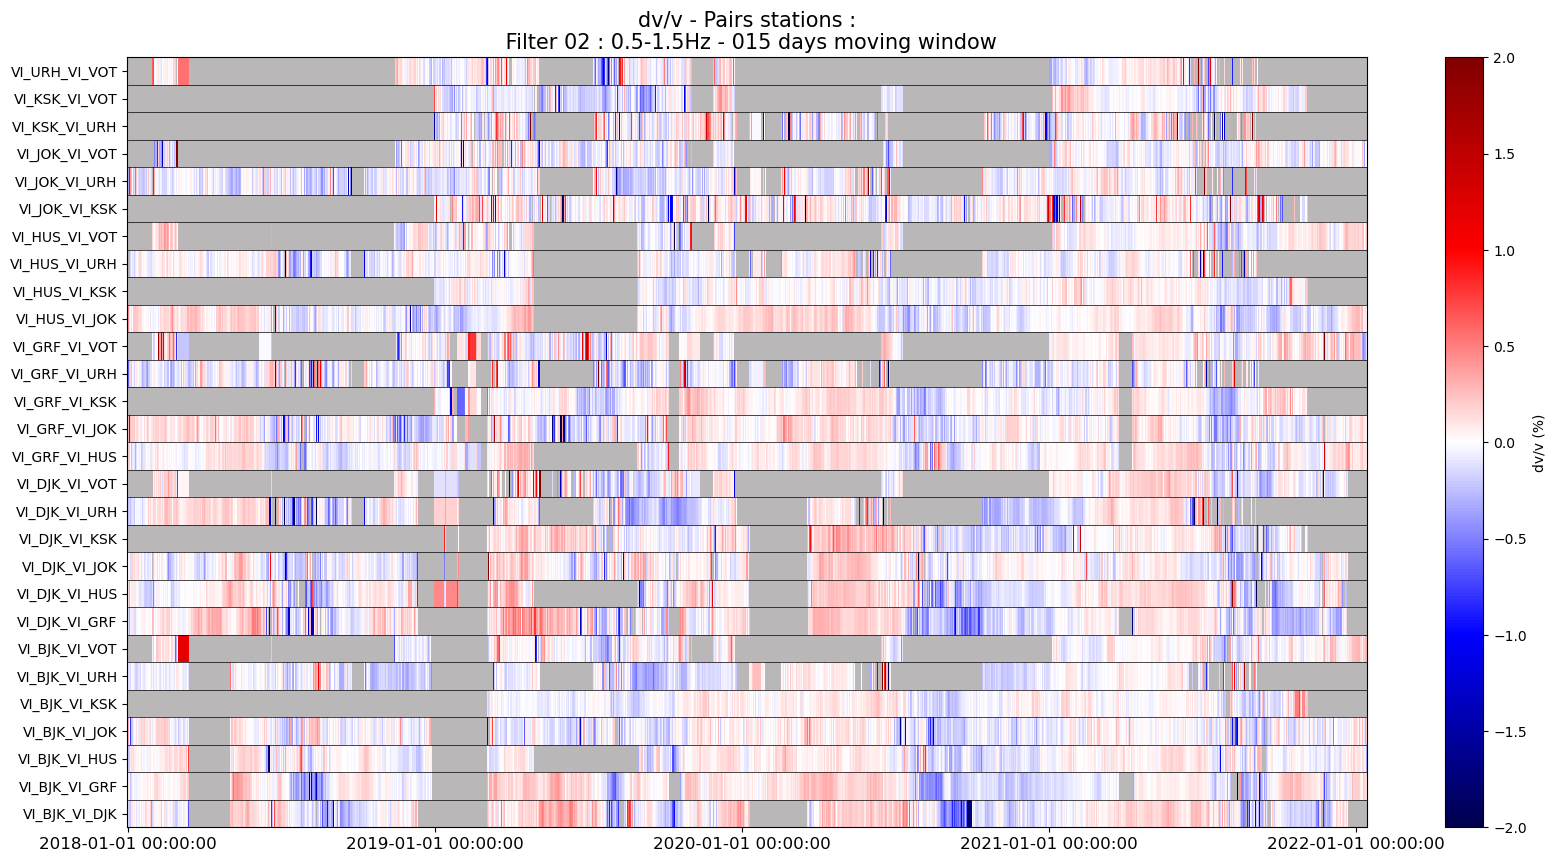

In [7]:
from matplotlib import colors

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor("#B9B7B7")
norm = colors.Normalize(vmin=-2,vmax=2)
#norm = colors.CenteredNorm()
plt.pcolormesh(xv,yv,m*-100, norm=norm, cmap='seismic')
for i in range(len(pair_name)) :
    temp = np.array([X[0],X[-1]])
    plt.plot(temp, [i-.5,i-.5], c='black',linewidth = .5)
plt.yticks(ticks=Y,labels=pair_name)
plt.xticks(ticks=idxNY,labels=NY, fontsize='12')
plt.title('dv/v - Pairs stations :\n Filter %s : 0.5-1.5Hz - %s days moving window' %(filterID, mwlength),
          fontsize='15')
plt.colorbar(label='dv/v (%)')
plt.show()

### Comparing with hydrology

In [8]:
dhydro = pd.read_csv('D:/MEMOIRE/HYDRO/ALL-DVV/vdv_2018-2022-20230322092719-able-panda.csv',delimiter =';',low_memory=False) 

In [9]:
dich = {}

for a in dhydro :
    if a != 'Time' :
        pQ = np.array(dhydro[a])
        nantest = np.array(pd.notna(pQ))
        Q = np.extract(nantest,pQ).astype(str)
        Q = np.char.replace(Q,',','.').astype(object)
        T = np.extract(nantest,dhydro['Time']).astype(object)
        R = np.block([[T], [Q]])
        dich.update({a: R})
    print(nantest)

NameError: name 'nantest' is not defined

In [ ]:
plt.figure(figsize=(15,5))
line = 1
for a in dich :
    if len(dich[a][0]) > 10 and line == 3:
        plt.plot(dich[a][0].astype(np.datetime64),dich[a][1].astype('float64'), label=a)
        plt.ylim(0,500)
    line += 1
plt.legend()
plt.show()

# Garbage

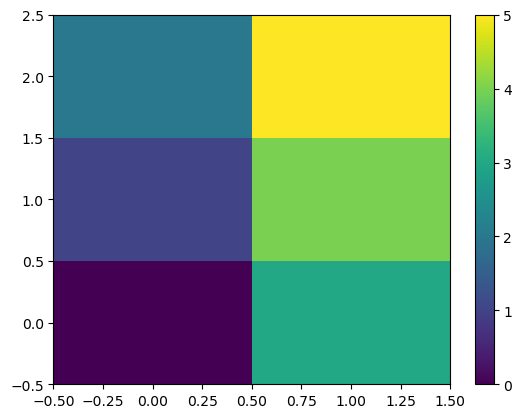

In [426]:
A = np.array([[0,0,0],[1,1,1]])
B = np.array([[0,1,2],[0,1,2]])
C = [[0,1,2],[3,4,5]]

plt.pcolormesh(A,B,C)
plt.colorbar()

In [300]:
X = list(range(0,5))
Y = list(range(0,5))
xv, yv = np.meshgrid(X, Y)

In [305]:
yv[0][1] = 10

In [306]:
yv

array([[ 0, 10,  0,  0,  0],
       [ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4]])